In [1]:
import EDShandler
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
import numpy as np
import numpy.matlib
#from scipy.sparse import csc_matrix, csr_matrix, spdiags, kron, eye
#from scipy.sparse.linalg import svds
from time import time
from math import ceil
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import NMF, FastICA
# import pyUSID as usid
%matplotlib inline
plt.style.use('seaborn')
plt.style.use({'font.size': 16, 'font.sans-serif': 'arial', 'font.weight': 'bold'})
t_start = time()

In [2]:
eds_object = EDShandler.ReadRawRpl('bruker_fuel.rpl', dtype_out='f4')
eds_object.get_metadata(dx=0.153, dx_unit='nm', dE=0.010, dE_unit='keV', E0 = -0.96)
#eds_object.write_h5('bruker_fuzz.h5')


Preparing to parse bruker_fuel.rpl
Preparing to read  bruker_fuel.raw
Reshaping          bruker_fuel.raw
Type casting       bruker_fuel.raw
Success!           bruker_fuel.raw


In [3]:
bfn = eds_object._raw_file_name
bfn = bfn.split('.')[0]
bfn

'bruker_fuel'

In [4]:
eds_object.get_metadata(dx=0.153, dx_unit='nm', dE=0.010, dE_unit='keV', E0 = -0.96)

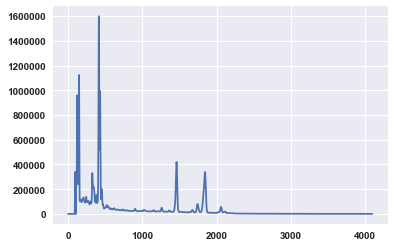

In [5]:
plt.plot(eds_object.get_sum_spectrum())

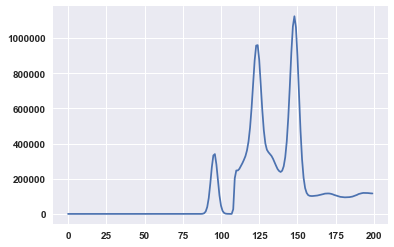

In [6]:
SS = eds_object.get_sum_spectrum()
XAXIS = eds_object._Spectroscopic_Values
plt.plot(SS[:200])

In [7]:
eds_object.trim_spectrally(min_chan=200, max_chan=800)
#eds_object.trim_spectrally(min_chan=60, max_chan=1860)
eds_object._specdata.shape

(1048576, 600)

In [8]:
eds_object.to_sparse()
eds_object.bin_NNM(N=8, M=2)

Sparse conversion on bruker_fuel.rpl
Sparse conversion on bruker_fuel.rpl complete!
Elapsed time 12.38099980354309.
Binning 8x8 spatial x2 spectral on bruker_fuel.rpl
Binning on bruker_fuel.rpl complete!
Elapsed time 4.02400016784668.


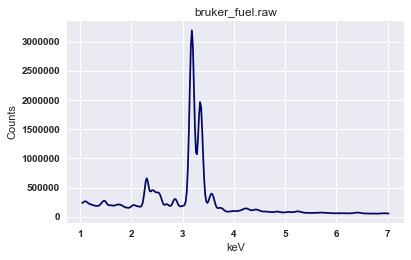

In [9]:
eds_object.plot_sum_spectrum();

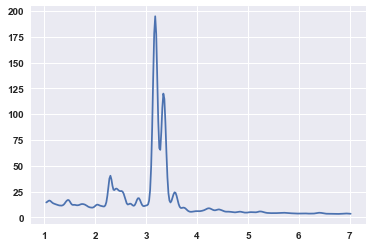

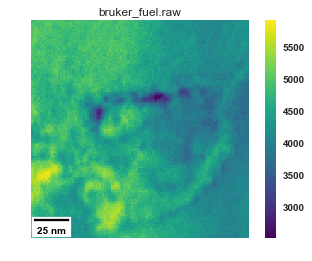

<Figure size 432x288 with 0 Axes>

(128, 128)

In [10]:
ss = eds_object.get_sum_spectrum();
plt.plot(eds_object._Spectroscopic_Values, ss/(eds_object._npixels));
eds_object.plot_sum_image();
si = eds_object.get_sum_image();
si.shape

Poisson scaling on bruker_fuel.rpl
Any warnings can probably be ignored; NaNs will be sanitized
Poisson scaling on bruker_fuel.rpl complete!
Elapsed time 0.3620002269744873.
Performing singular value decomposition with 16 components.
Finished singular value decomposition with 16 components.
Elapsed time 2.2839999198913574.


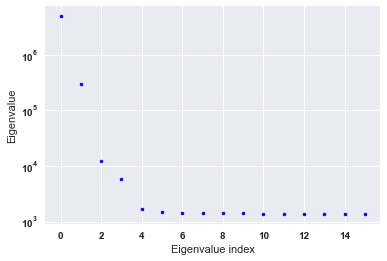

In [11]:
eds_object.noise_scale()
k=16
_, _, _ = eds_object.scaled_svd(k=k, scree=True)

In [12]:
trunc = 5
U, S, V = eds_object.get_truncated_model(scaled=True, trunc=trunc)
T, P = eds_object.get_truncated_model(scaled=False, trunc=trunc)

Shape of A: (16384, 16)
Shape of S: (300, 16)


In [13]:
L = U @ np.diag(S)  # The 'L'eft side of the singular value decomposition
print(L.shape)
D_tilde = T @ P.T
print(D_tilde.shape)

(16384, 5)
(16384, 300)


In [14]:
def varimax(P, gamma = 1.0, q = 250, tol = 1e-5):
    p, k = P.shape
    R = np.eye(k)
    #Lambda = P @ R
    #u,s,vh = np.linalg.svd((P.T@(np.power(Lambda,3) - (gamma) * np.dot(Lambda, np.diag(np.diag(np.power(Lambda,2)))))))
    #R = u @ vh
    
    d = 0
    for i in range(q):
        d_old = d
        Lambda = P @ R
        u,s,vh = np.linalg.svd((P.T@(np.power(Lambda,3) - (gamma/p) * np.dot(Lambda, np.diag(np.diag(np.power(Lambda,2)))))))
        R = u @ vh
        d = np.sum(s)
        if d_old != 0 and np.abs((d-d_old)/d) < tol: break
    if i == q-1:
        print('max iteration hit')
    return  (P @ R), R

In [15]:
def flip_positive(T, P):
    a1, b1 = T.shape
    a2, b2 = P.shape
    assert b1 == b2, 'Inconsistent numbers of columns'
    for i in range(b1):
        if (P[:,i].sum() < 0) and (T[:, i].sum() < 0):
            P[:, i] *= -1
            T[:, i] *= -1
    return T, P

def normalize_endmembers(T, P):
    a1, b1 = T.shape
    a2, b2 = P.shape
    assert b1 == b2, 'Inconsistent numbers of columns'
    for i in range(b1):
        X = P[:,i].sum()
        P[:, i] /= X
        T[:, i] *= X
    return T, P

def normalize_abundances(T, P):
    a1, b1 = T.shape
    a2, b2 = P.shape
    assert b1 == b2, 'Inconsistent numbers of columns'
    for i in range(b1):
        X = T[:,i].sum()
        P[:, i] *= X
        T[:, i] /= X
    return T, P

In [16]:
Pss, Rp = varimax(P)
Pss.shape

(300, 5)

In [17]:
Tss = T @ Rp

In [18]:
def plot_together(eds_object, *, T=T, P=P, cmap='seismic', symmetric=True,
                  title_string='', abundance_string='Abundance',
                  endmember_string='Endmember'):
    p = T.shape[1]
    fig, cax = plt.subplots(nrows=p, ncols=2, figsize=(8, 3*p))
    for i in range(p):
        cax[i, 0].plot(eds_object._Spectroscopic_Values,P[:, i])
        cax[i, 0].set_title(f'{endmember_string} #{i}')
        if symmetric == True:
            handle = cax[i, 1].imshow(T[:,i].reshape(si.shape),
                                  cmap=cmap,vmin=-np.abs(T[:,i]).max(),
                                  vmax=np.abs(T[:,i]).max())
        elif symmetric == False:
            handle = cax[i, 1].imshow(T[:,i].reshape(si.shape),
                                  cmap=cmap,vmin=0,
                                  vmax=np.abs(T[:,i]).max())
        cax[i, 1].set_title(f'{abundance_string} #{i}')
        fig.colorbar(handle, ax=cax[i, 1], shrink=.65, orientation='horizontal')
        cax[i, 1] = eds_object._generate_scalebar(cax[i, 1])
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle(title_string, fontsize=16)

In [19]:
def cross_matrix(mat, long_axis=None):
    if long_axis == None:
        x, y = mat.shape
        if x > y:
            cross_mat = mat.T @ mat
        elif x < y:
            cross_mat = mat @ mat.T
        elif x == y:
            cross_mat = mat
        else:
            raise ValueError('Could not parse mat.shape')
    elif long_axis == 0:
        cross_mat = mat.T @ mat
    elif long_axis == 1:
        cross_mat = mat @ mat.T
    else:
        raise ValueError('long_axis must be None, 0, or 1.')

    cross_mat = np.abs(cross_mat)
    with plt.style.context('classic'):
        plt.colorbar(plt.matshow(cross_mat, norm=LogNorm(vmin=cross_mat.min(),
                                 vmax=cross_mat.max()), cmap='inferno'))

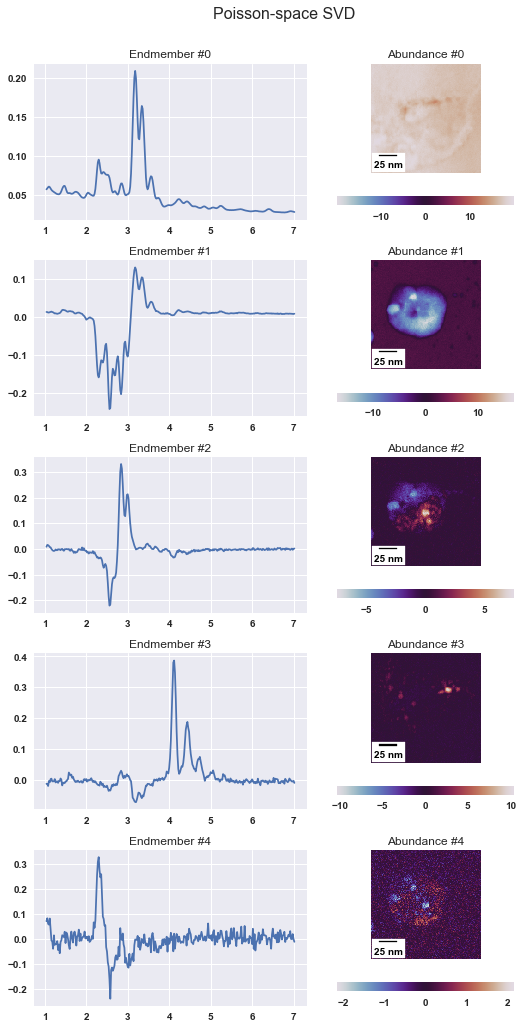

In [20]:
plot_together(eds_object, T=L, P=V.T, cmap='twilight', title_string='Poisson-space SVD')
plt.savefig(bfn + '_poisson_svd.png', dpi=200)

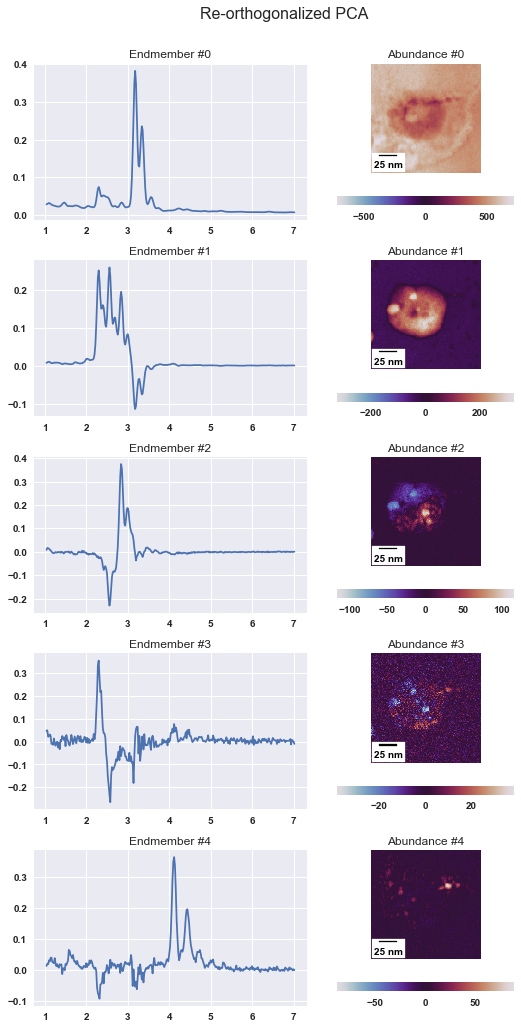

In [21]:
T, P = flip_positive(T, P)
plot_together(eds_object, T=T, P=P, cmap='twilight', title_string='Re-orthogonalized PCA')
plt.savefig(bfn + '_fPCA.png', dpi=200)

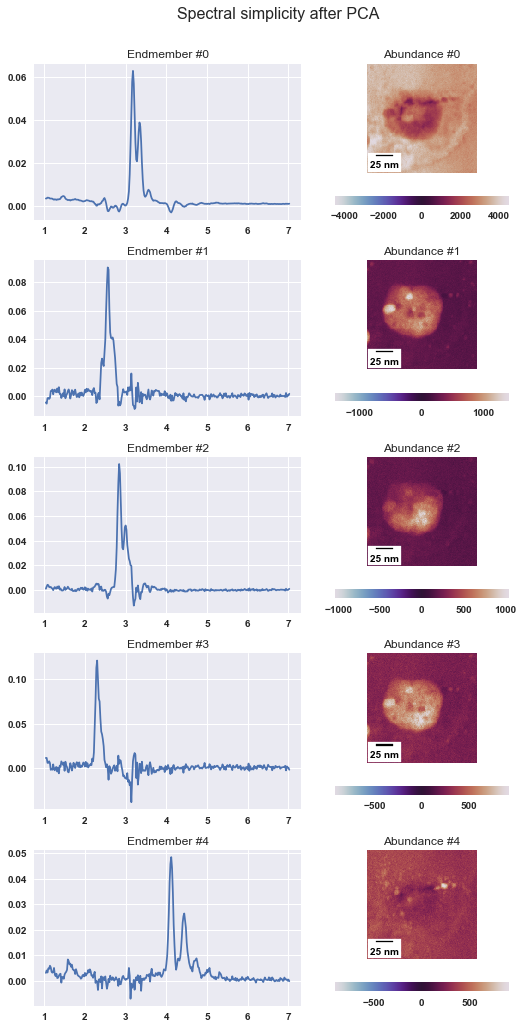

In [22]:
Tss, Pss = normalize_endmembers(Tss, Pss)
plot_together(eds_object, T=Tss, P=Pss, cmap='twilight', title_string='Spectral simplicity after PCA')
plt.savefig(bfn + '_spectral_simp.png', dpi=200)

In [23]:
print(T.shape)
Tnorm = np.zeros(T.shape)
Pnorm = np.zeros(P.shape)

for i in range(trunc):
    fact = np.sqrt(np.dot(T[:, i].T, T[:, i]))
    Tnorm[:, i] = T[:, i].flatten() / fact
    Pnorm[:, i] = ((P[:, i].flatten()).T * fact).flatten()
#cross_matrix(Tnorm)
#cross_matrix(Pnorm)

(16384, 5)


In [24]:
Tspat, Rspat = varimax(Tnorm)
#cross_matrix(Tspat)
Pspat = (np.linalg.inv(Rspat) @ Pnorm.T).T
#cross_matrix(Pspat)
#print((Tspat @ Pspat.T).sum())
#print((T*P.T).sum())

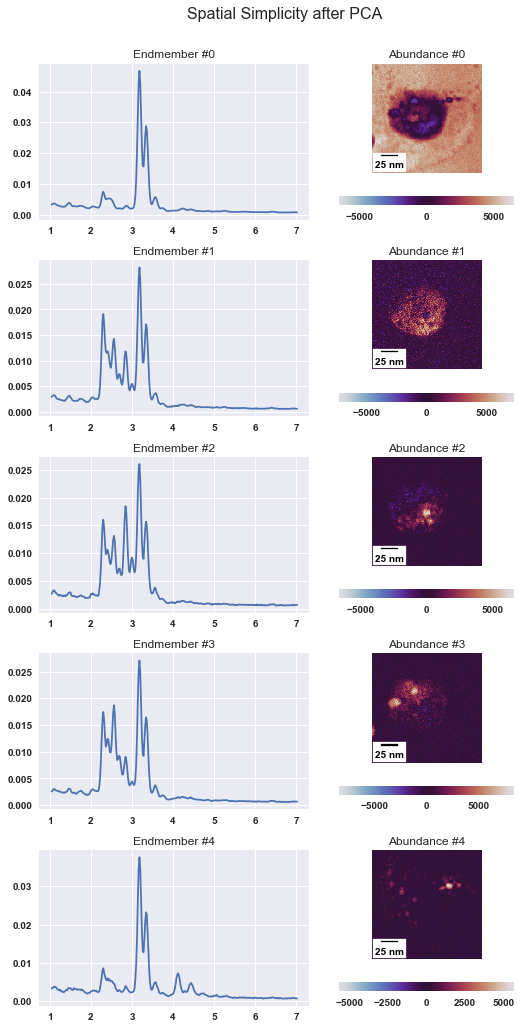

In [25]:
Tspat, Pspat = flip_positive(Tspat, Pspat)
Tspat, Pspat = normalize_endmembers(Tspat, Pspat)
plot_together(eds_object, T=Tspat, P=Pspat, cmap='twilight', title_string='Spatial Simplicity after PCA')
plt.savefig(bfn + '_spatial_simp.png', dpi=200)

ICAiterations: 5


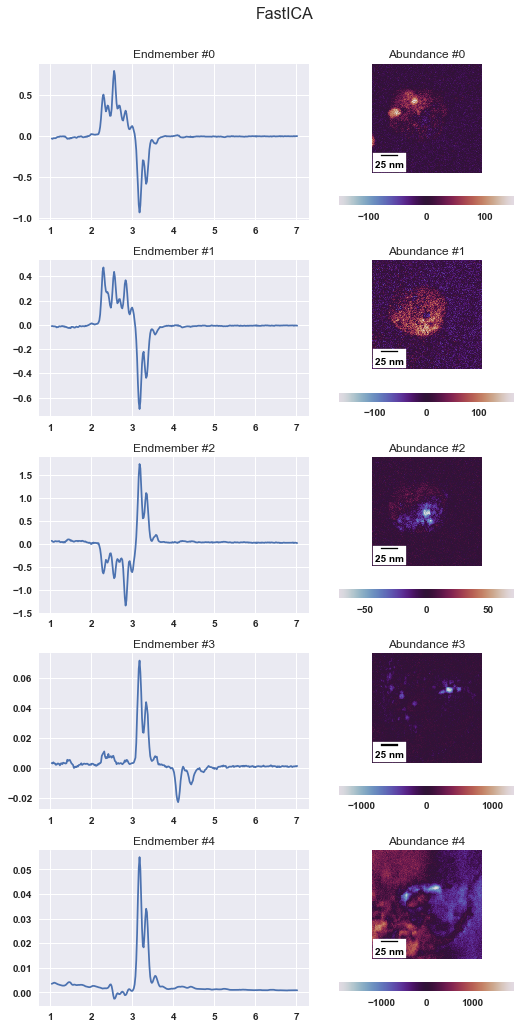

In [26]:
ica_object = FastICA(n_components=trunc, algorithm='parallel', random_state=None, fun='cube')
W_ica = ica_object.fit_transform(np.maximum(D_tilde, 0))
H_ica = ica_object.mixing_
W_ica, H_ica = flip_positive(W_ica, H_ica)
W_ica, H_ica = normalize_endmembers(W_ica, H_ica)
print(f'ICAiterations: {ica_object.n_iter_}')
plot_together(eds_object, T=W_ica, P=H_ica, cmap='twilight', symmetric=True, title_string='FastICA')
plt.savefig(bfn + '_ICA.png', dpi=200)

HICAiterations: 11


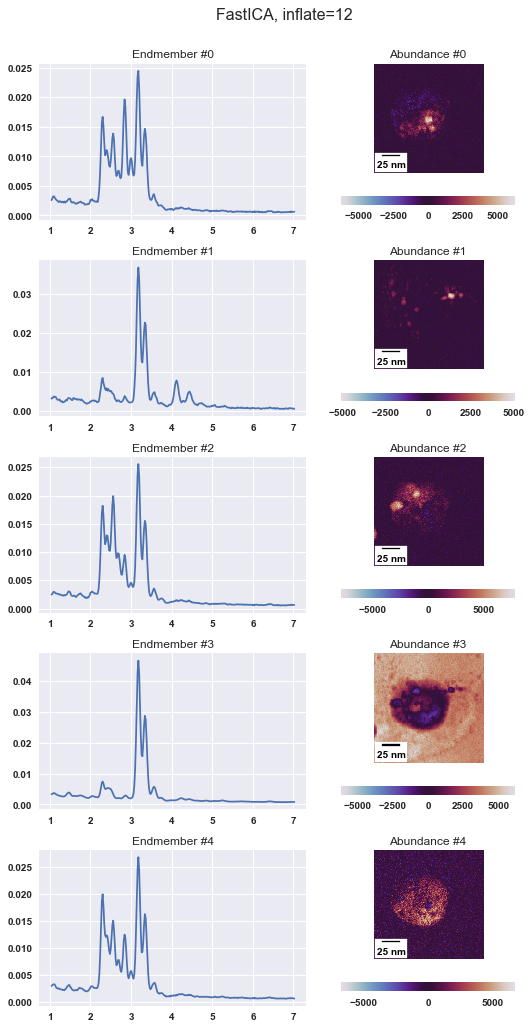

In [27]:
npix, nchannels = D_tilde.shape
inflate = 12
D_hica = np.zeros((npix*inflate, nchannels))
D_hica[:npix, :] = D_tilde
hica_object = FastICA(n_components=trunc, algorithm='parallel', random_state=None, fun='cube')
W_hica = hica_object.fit_transform(np.maximum(D_hica, 0))
print(f'HICAiterations: {hica_object.n_iter_}')
del D_hica
W_hica = W_hica[:npix, :]
H_hica = hica_object.mixing_
W_hica, H_hica = flip_positive(W_hica, H_hica)
W_hica, H_hica = normalize_endmembers(W_hica, H_hica)
plot_together(eds_object, T=W_hica, P=H_hica, symmetric=True, cmap='twilight', title_string=f'FastICA, inflate={inflate}')
plt.savefig(bfn + '_HICA' + str(inflate) + '.png', dpi=200)

In [28]:
W = np.maximum(Tspat,0)
H = np.maximum(Pspat,0)

866.9821031107984


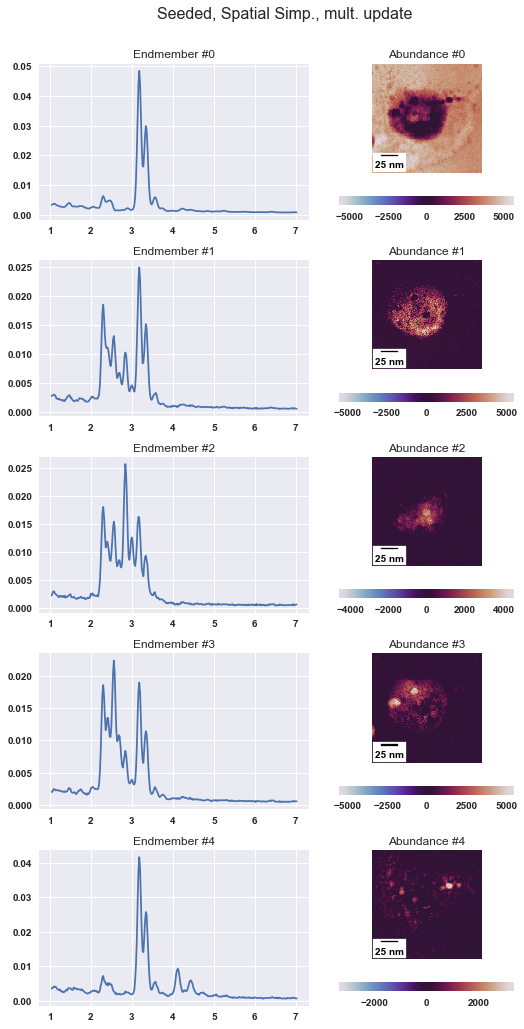

In [29]:
nmf_seeded1 = NMF(n_components=trunc, init='custom', random_state=None, solver='mu', max_iter=400)
W_seeded1 = nmf_seeded1.fit_transform(np.maximum(D_tilde, 0), W=W, H=H.T)
H_seeded1 = nmf_seeded1.components_
plot_together(eds_object, T=W_seeded1, P=H_seeded1.T, cmap='twilight', title_string='Seeded, Spatial Simp., mult. update')
print(nmf_seeded1.reconstruction_err_)
plt.savefig(bfn + '_nmf_mu_spat_seed.png', dpi=200)

83.46627253328307


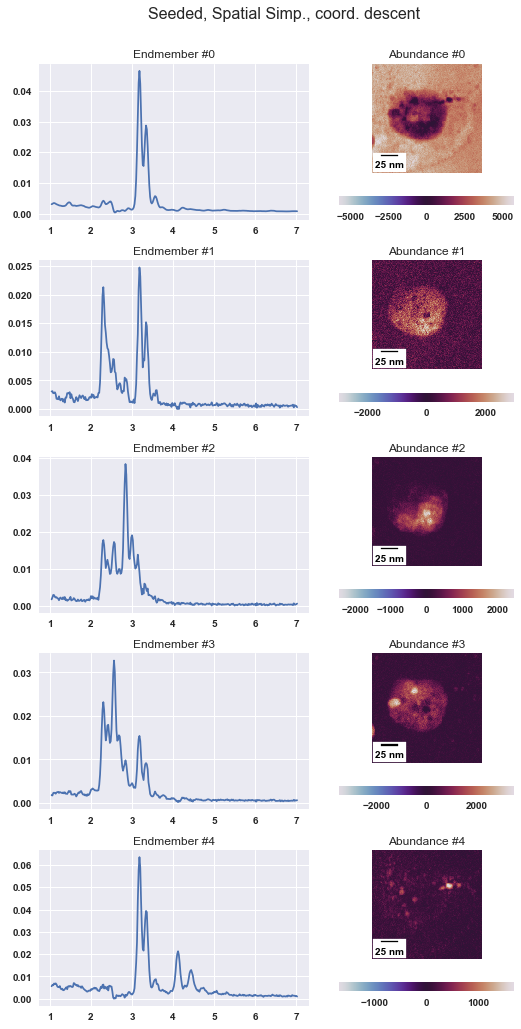

In [30]:
nmf_seeded2 = NMF(n_components=trunc, init='custom', random_state=None, solver='cd', max_iter=400)
W_seeded2 = nmf_seeded2.fit_transform(np.maximum(D_tilde, 0), W=W, H=H.T)
H_seeded2 = nmf_seeded2.components_
plot_together(eds_object, T=W_seeded2, P=H_seeded2.T, cmap='twilight', title_string='Seeded, Spatial Simp., coord. descent')
print(nmf_seeded2.reconstruction_err_)
plt.savefig(bfn + '_nmf_cd_spat_seed.png', dpi=200)

125.05289936989841


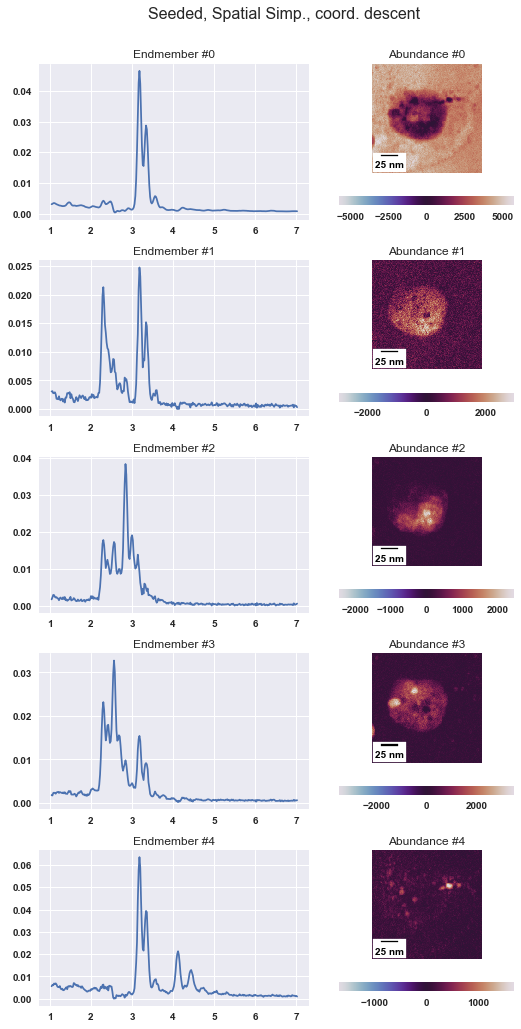

In [31]:
W = np.maximum(Tss,0)
H = np.maximum(Pss,0)
nmf_seeded3 = NMF(n_components=trunc, init='custom', random_state=None, solver='cd', max_iter=400)
W_seeded3 = nmf_seeded3.fit_transform(np.maximum(D_tilde, 0), W=W, H=H.T)
H_seeded3 = nmf_seeded3.components_
plot_together(eds_object, T=W_seeded2, P=H_seeded2.T, cmap='twilight', title_string='Seeded, Spatial Simp., coord. descent')
print(nmf_seeded3.reconstruction_err_)
plt.savefig(bfn + '_nmf_cd_spec_seed.png', dpi=200)

. indicates convergence, * indicates MAX_ITER hit.
Numerical values are new best reconstruction errors (lower is better).
 
.02064.1331
.......Elapsed time 13.232999801635742.


13.232999801635742

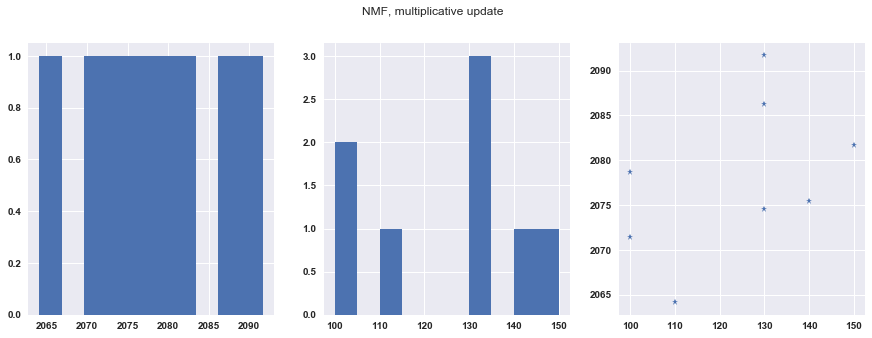

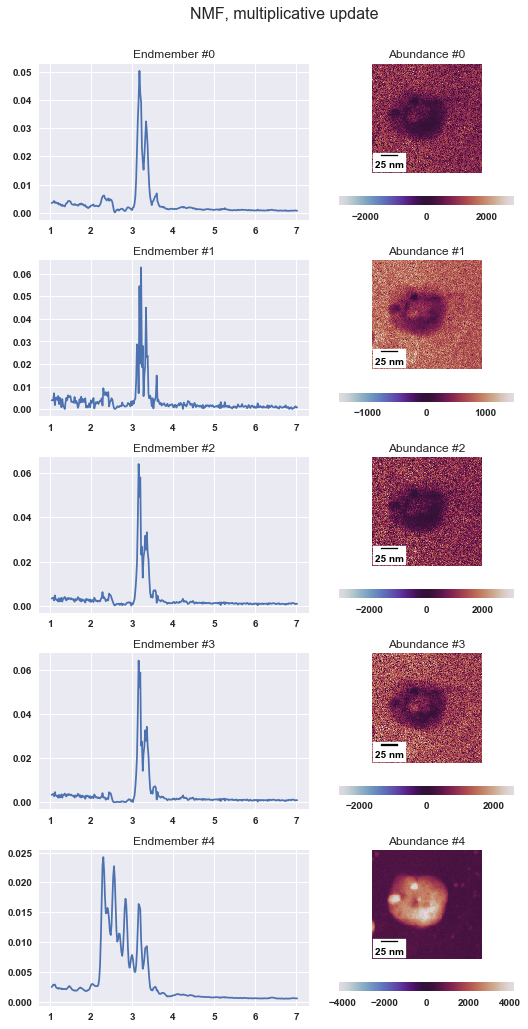

In [32]:
EDShandler.tic()
MAX_ITER = 2000
nmf_object = NMF(n_components=trunc, init='random', random_state=None,
                 solver='mu', max_iter=MAX_ITER)
obj_func = np.inf
obj_func_list = []
n_iter_list = []
print('. indicates convergence, * indicates MAX_ITER hit.')
print('Numerical values are new best reconstruction errors (lower is better).')
print(' ')
for i in range(8):
    W_temp = nmf_object.fit_transform(np.maximum(D_tilde, 0))
    H_temp = nmf_object.components_
    obj_func_list.append(nmf_object.reconstruction_err_)
    if nmf_object.n_iter_ == MAX_ITER:
        print('*', end='')
    else:
        print('.', end='')
    if nmf_object.reconstruction_err_ < obj_func:
        H_final = H_temp
        W_final = W_temp
        obj_func = nmf_object.reconstruction_err_
        print(f'{nmf_object.reconstruction_err_:010.08}\n', end='')

    n_iter_list.append(nmf_object.n_iter_)

mu_obj_funcs = obj_func_list
mu_n_iters = n_iter_list
    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax[0].hist(obj_func_list)
ax[1].hist(n_iter_list)
ax[2].plot(n_iter_list, obj_func_list, '*')
fig.suptitle('NMF, multiplicative update')
W_final, H_final = normalize_endmembers(W_final, H_final.T)
plot_together(eds_object, T=W_final, P=H_final, cmap='twilight',
              title_string='NMF, multiplicative update')
plt.savefig(bfn + '_nmf_mu_unseeded.png', dpi=200)
EDShandler.toc()

. indicates convergence, * indicates MAX_ITER hit.
Numerical values are new best reconstruction errors (lower is better).
 
.079.486887
.078.174475
.068.989163
.....Elapsed time 61.055999994277954.


61.055999994277954

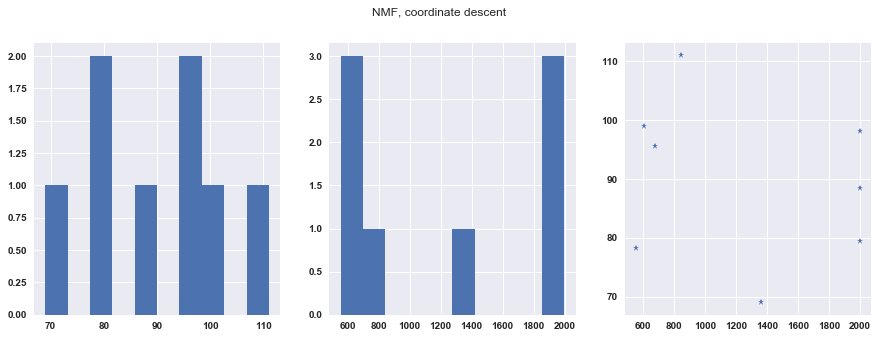

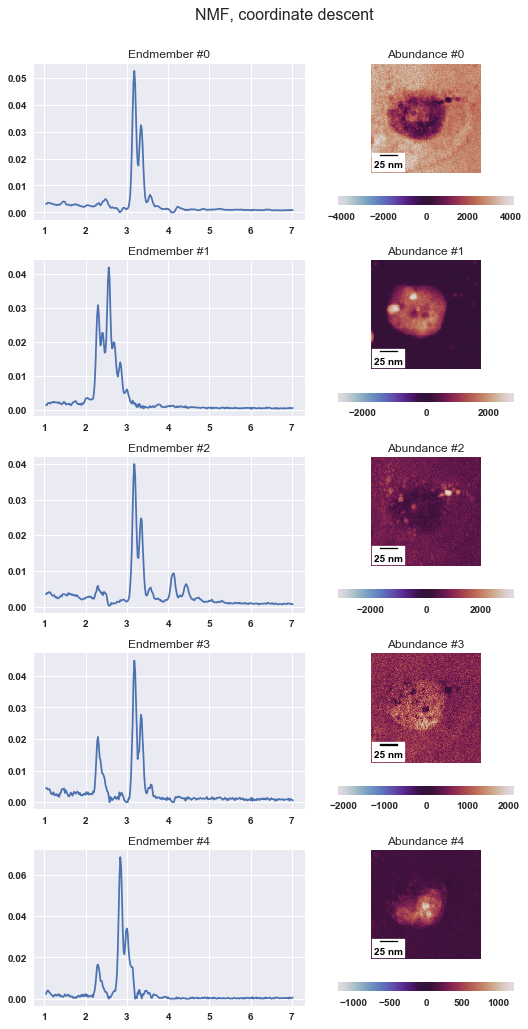

In [33]:
EDShandler.tic()
MAX_ITER = 2000
nmf_object = NMF(n_components=trunc, init='random', random_state=None,
                 solver='cd', max_iter=MAX_ITER)
obj_func = np.inf
obj_func_list = []
n_iter_list = []
print('. indicates convergence, * indicates MAX_ITER hit.')
print('Numerical values are new best reconstruction errors (lower is better).')
print(' ')
for i in range(8):
    W_temp = nmf_object.fit_transform(np.maximum(D_tilde, 0))
    H_temp = nmf_object.components_
    obj_func_list.append(nmf_object.reconstruction_err_)
    if nmf_object.n_iter_ == MAX_ITER:
        print('*', end='')
    else:
        print('.', end='')
    if nmf_object.reconstruction_err_ < obj_func:
        H_final2 = H_temp
        W_final2 = W_temp
        obj_func = nmf_object.reconstruction_err_
        print(f'{nmf_object.reconstruction_err_:010.08}\n', end='')

    n_iter_list.append(nmf_object.n_iter_)

cd_obj_funcs = obj_func_list
cd_n_iters = n_iter_list
    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax[0].hist(obj_func_list)
ax[1].hist(n_iter_list)
ax[2].plot(n_iter_list, obj_func_list, '*')
fig.suptitle('NMF, coordinate descent')
W_final2, H_final2 = normalize_endmembers(W_final2, H_final2.T)
plot_together(eds_object, T=W_final2, P=H_final2, cmap='twilight',
              title_string='NMF, coordinate descent')
plt.savefig(bfn + '_nmf_cd_unseeded.png', dpi=200)
EDShandler.toc()

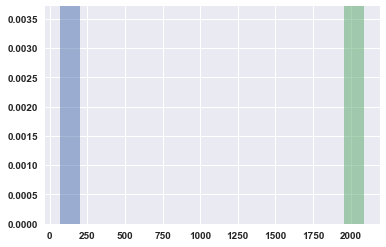

In [34]:
fig, ax = plt.subplots()
ofs = np.vstack([cd_obj_funcs, mu_obj_funcs]);
ax.hist(ofs.T, 15, alpha=0.5, density=True, histtype='bar', stacked=True);

0000	0020	0040	0060	0080	0100	0120	

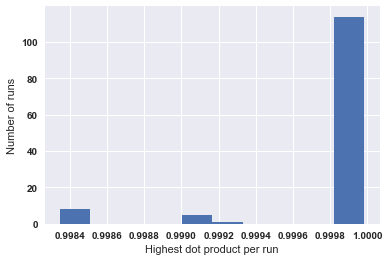

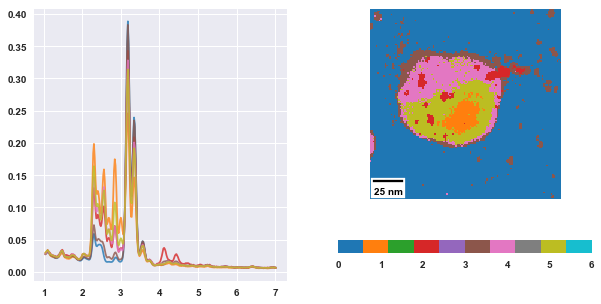

In [35]:
endmembers, gmm, dot_list = eds_object.perform_clustering(method='gmm', target='Svd',
                                                         num_clusters=6, trunc=trunc+1, tol=1e-3,
                                                         max_iter=200, MAX_TRIES=128,
                                                         cmap='tab10')

In [36]:
t_end = time()
print(f'Elapsed: {t_end-t_start} seconds.')

Elapsed: 227.71599984169006 seconds.


Gaussian mixture model better for noisier data!!!!

# Header
## lower
### lowest
$x^{2}$ <br>
<br>
asdf
asdf